# 1. Import Libraries

In [2]:
import os
import glob as glob
import pandas as pd
import numpy as np
import json
from collections import defaultdict
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

/Users/andrewnorris/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2. Prepare the data

We extract the dataset list from `datasets.json` from RCDatasets, and named it `idx2set`, which is a list of all the datasets we have. And we get all the cooccurence data from `bucket_final` and stored in `datasets`, which is a list of list of datasets appeared in each publications. 

In [3]:
# %cd "C:/git/RCDatasets/"
%cd "/Users/andrewnorris/RCDatasets"

/Users/andrewnorris/RCDatasets


In [4]:
# write list of IDs from each datasets.json entry 

datasets_list = [] # ||list of every author's hash

with open('datasets.json', encoding='utf-8') as json_file:
    datasets = json.load(json_file)
    for entry in datasets:
        datasets_list.append(entry['id'])
        
idx2set = datasets_list

In [5]:
# %cd "C:/git/RCGraph/bucket_final"
%cd "/Users/andrewnorris/RCGraph/bucket_final"

/Users/andrewnorris/RCGraph/bucket_final


In [6]:
# read contents from all json partitions 
contents = []
for file_name in glob.glob('*.json'):
    with open(file_name, encoding='utf-8') as f:
        contents.append(json.load(f)) 

In [7]:
# extract datasets
datasets = []  # ||list of all authors (their hashes) for each publication
for partition in contents:
    for publication in partition:
        datasets.append(publication['datasets'])    

In [8]:
datasets[30:40]

[['dataset-027'],
 ['dataset-027'],
 ['dataset-027'],
 ['dataset-027'],
 ['dataset-027'],
 ['dataset-870', 'dataset-881'],
 ['dataset-870'],
 ['dataset-870'],
 ['dataset-870', 'dataset-881'],
 ['dataset-870']]

There are totally 3,445 records of datasets in bucket final.

In [9]:
total_num = 0
for i in datasets:
    total_num += len(i)
total_num

3445

# 3. Get co-occurrence matrix; data framing for visualizations

In [10]:
def get_cooccurrences(datasets): 
    """ 
    Compute co-occurrences between datasets from complete list publications and linked datasets

    args: 
        - datasets: nested list of dataset(s) from all publications 
    return:
        - A dictionary of dictionaries, where:

              {'dataset-AAA':{'dataset-YYY': n1, 'dataset-ZZZ': n2},...}

          dataset-AAA: key dataset
          dataset-YYY/ZZZ: dataset(s) linked with dataset-AAA
          n1/n2: number of times dataset-YYY/ZZZ occurs with dataset-AAA
    """
    
    cooccur_counts = defaultdict(lambda: defaultdict(int))
    for linked_data in datasets:
    # linked_data is a nested list of linked datasets within complete datasets list
        for i, dsets in enumerate(linked_data):
            for k in range(1, len(linked_data) + 1):
                if i+k < len(linked_data):
                    cooccur_counts[dsets][linked_data[i+k]] += 1
                if i-k >= 0:
                    cooccur_counts[dsets][linked_data[i-k]] += 1
    return cooccur_counts 

In [11]:
def build_cooccurrence_mat_from_counts (idx2set, cooccur_counts):
    """ Build a cooccurrence matrix from counts and a dataset list
    args:
        - idx2set: the whole list of datasets from dataset.json with length N
        - cooccur_counts: a dictionary of dictionaries, where

              cooccur_counts[dataset1][dataset2]

          is how often dataset1 cooccurs with dataset2
    return:
        - mat: an NxN matrix (symmetric) of the occurrence counts of the
               datasets in idx2set
    """
    mat_size = len(idx2set)
    mat = np.zeros([mat_size, mat_size])
    for i in tqdm.tqdm_notebook(range(mat_size)):
        for j in range(i, mat_size):
            try:
                mat[i][j] = cooccur_counts[idx2set[i]][idx2set[j]]
                mat[j][i] = cooccur_counts[idx2set[j]][idx2set[i]]
            except:
                continue
    return mat

In [12]:
# dictionary of cooccurrence counts
cooccur_counts = get_cooccurrences(datasets)
cooccur_counts

defaultdict(<function __main__.get_cooccurrences.<locals>.<lambda>()>,
            {'dataset-870': defaultdict(int,
                         {'dataset-881': 17,
                          'dataset-885': 1,
                          'dataset-681': 1,
                          'dataset-886': 1,
                          'dataset-898': 3,
                          'dataset-784': 3,
                          'dataset-058': 1,
                          'dataset-880': 1,
                          'dataset-875': 1,
                          'dataset-876': 1,
                          'dataset-680': 5,
                          'dataset-699': 1,
                          'dataset-883': 1,
                          'dataset-200': 1,
                          'dataset-573': 3,
                          'dataset-894': 4,
                          'dataset-694': 5,
                          'dataset-877': 1,
                          'dataset-878': 1,
                          'dataset-879': 1,
   

In [13]:
mat = build_cooccurrence_mat_from_counts(datasets_list, cooccur_counts)

In [14]:
mat

array([[ 0., 17.,  0., ...,  0.,  0.,  0.],
       [17.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [15]:
from scipy.sparse import coo_matrix

In [16]:
mat_full = coo_matrix(mat)

In [17]:
mat_full

<937x937 sparse matrix of type '<class 'numpy.float64'>'
	with 1688 stored elements in COOrdinate format>

In [18]:
mat_full.eliminate_zeros()

In [19]:
mat_full = coo_matrix.eliminate_zeros(mat_full)

In [20]:
# create pd dataframe of cooccurrence matrix; columns, indices are complete list of datasets

mat_df = pd.DataFrame(mat, index=datasets_list, columns=datasets_list)
mat_df.head()

,dataset-001,dataset-002,dataset-003,dataset-004,dataset-005,dataset-006,dataset-007,dataset-008,dataset-009,dataset-010,...,dataset-956,dataset-957,dataset-958,dataset-960,dataset-961,dataset-963,dataset-964,dataset-965,dataset-966,dataset-967
dataset-001,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dataset-002,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dataset-003,0.0,0.0,0.0,0.0,4.0,2.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dataset-004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dataset-005,0.0,0.0,4.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
mat_df_filled = mat_df.loc[:, (mat_df != 0).any(axis=0)]

In [22]:
mat_df_filled.head()

,dataset-001,dataset-002,dataset-003,dataset-005,dataset-006,dataset-008,dataset-010,dataset-012,dataset-013,dataset-015,...,dataset-923,dataset-928,dataset-929,dataset-935,dataset-936,dataset-941,dataset-943,dataset-950,dataset-952,dataset-954
dataset-001,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dataset-002,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dataset-003,0.0,0.0,0.0,4.0,2.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dataset-004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dataset-005,0.0,0.0,4.0,0.0,8.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are 1,688 dataset links recorded in total.

In [23]:
SUM = 0
for i in mat:
    for j in i:
        if j != 0:
            SUM += 1
SUM

1688

In [24]:
# create source-target network of dataset links
# for use in networkx -- 'source','target' columns required

mat_network = mat_df.stack()
mat_network = mat_network[mat_network >= 1].rename_axis(('source', 'target')).reset_index(name='weight')
mat_network

,source,target,weight
0,dataset-001,dataset-002,17.0
1,dataset-001,dataset-026,1.0
2,dataset-001,dataset-049,1.0
3,dataset-002,dataset-001,17.0
4,dataset-002,dataset-026,1.0
...,...,...,...
1683,dataset-950,dataset-480,1.0
1684,dataset-950,dataset-493,1.0
1685,dataset-950,dataset-943,1.0
1686,dataset-952,dataset-943,1.0


In [25]:
# unique pairs of linked datasets, sorted by number of links

dset_pairs = mat_network

pairs_list = []
nodemap = {}
present = []

for index, row in dset_pairs.iterrows():
    if row['source'] not in nodemap.keys():
        nodemap[row['target']] = row['source']
        present.append(1)
    else:
        present.append(0)

dset_pairs['present'] = present

dset_pairs = dset_pairs[dset_pairs['present']==1]
dset_pairs = dset_pairs.drop(columns=['present'])
dset_pairs = dset_pairs.rename(columns={'source':'datasetA','target':'datasetB','weight':'num_links'}).sort_values(by='num_links',ascending=False).reset_index(drop=True)
dset_pairs.head()


,datasetA,datasetB,num_links
0,dataset-017,dataset-048,27.0
1,dataset-001,dataset-002,17.0
2,dataset-012,dataset-013,8.0
3,dataset-017,dataset-033,7.0
4,dataset-017,dataset-049,6.0


# 4. Co-occurrence visualizations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2331f190>]],
      dtype=object)

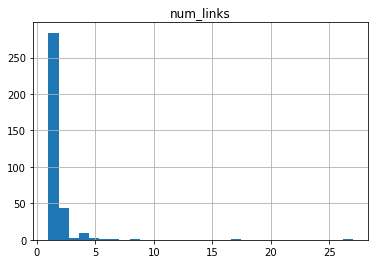

In [26]:
# histogram of number of links
dset_pairs.hist(column='num_links', bins=30)


/Users/andrewnorris/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


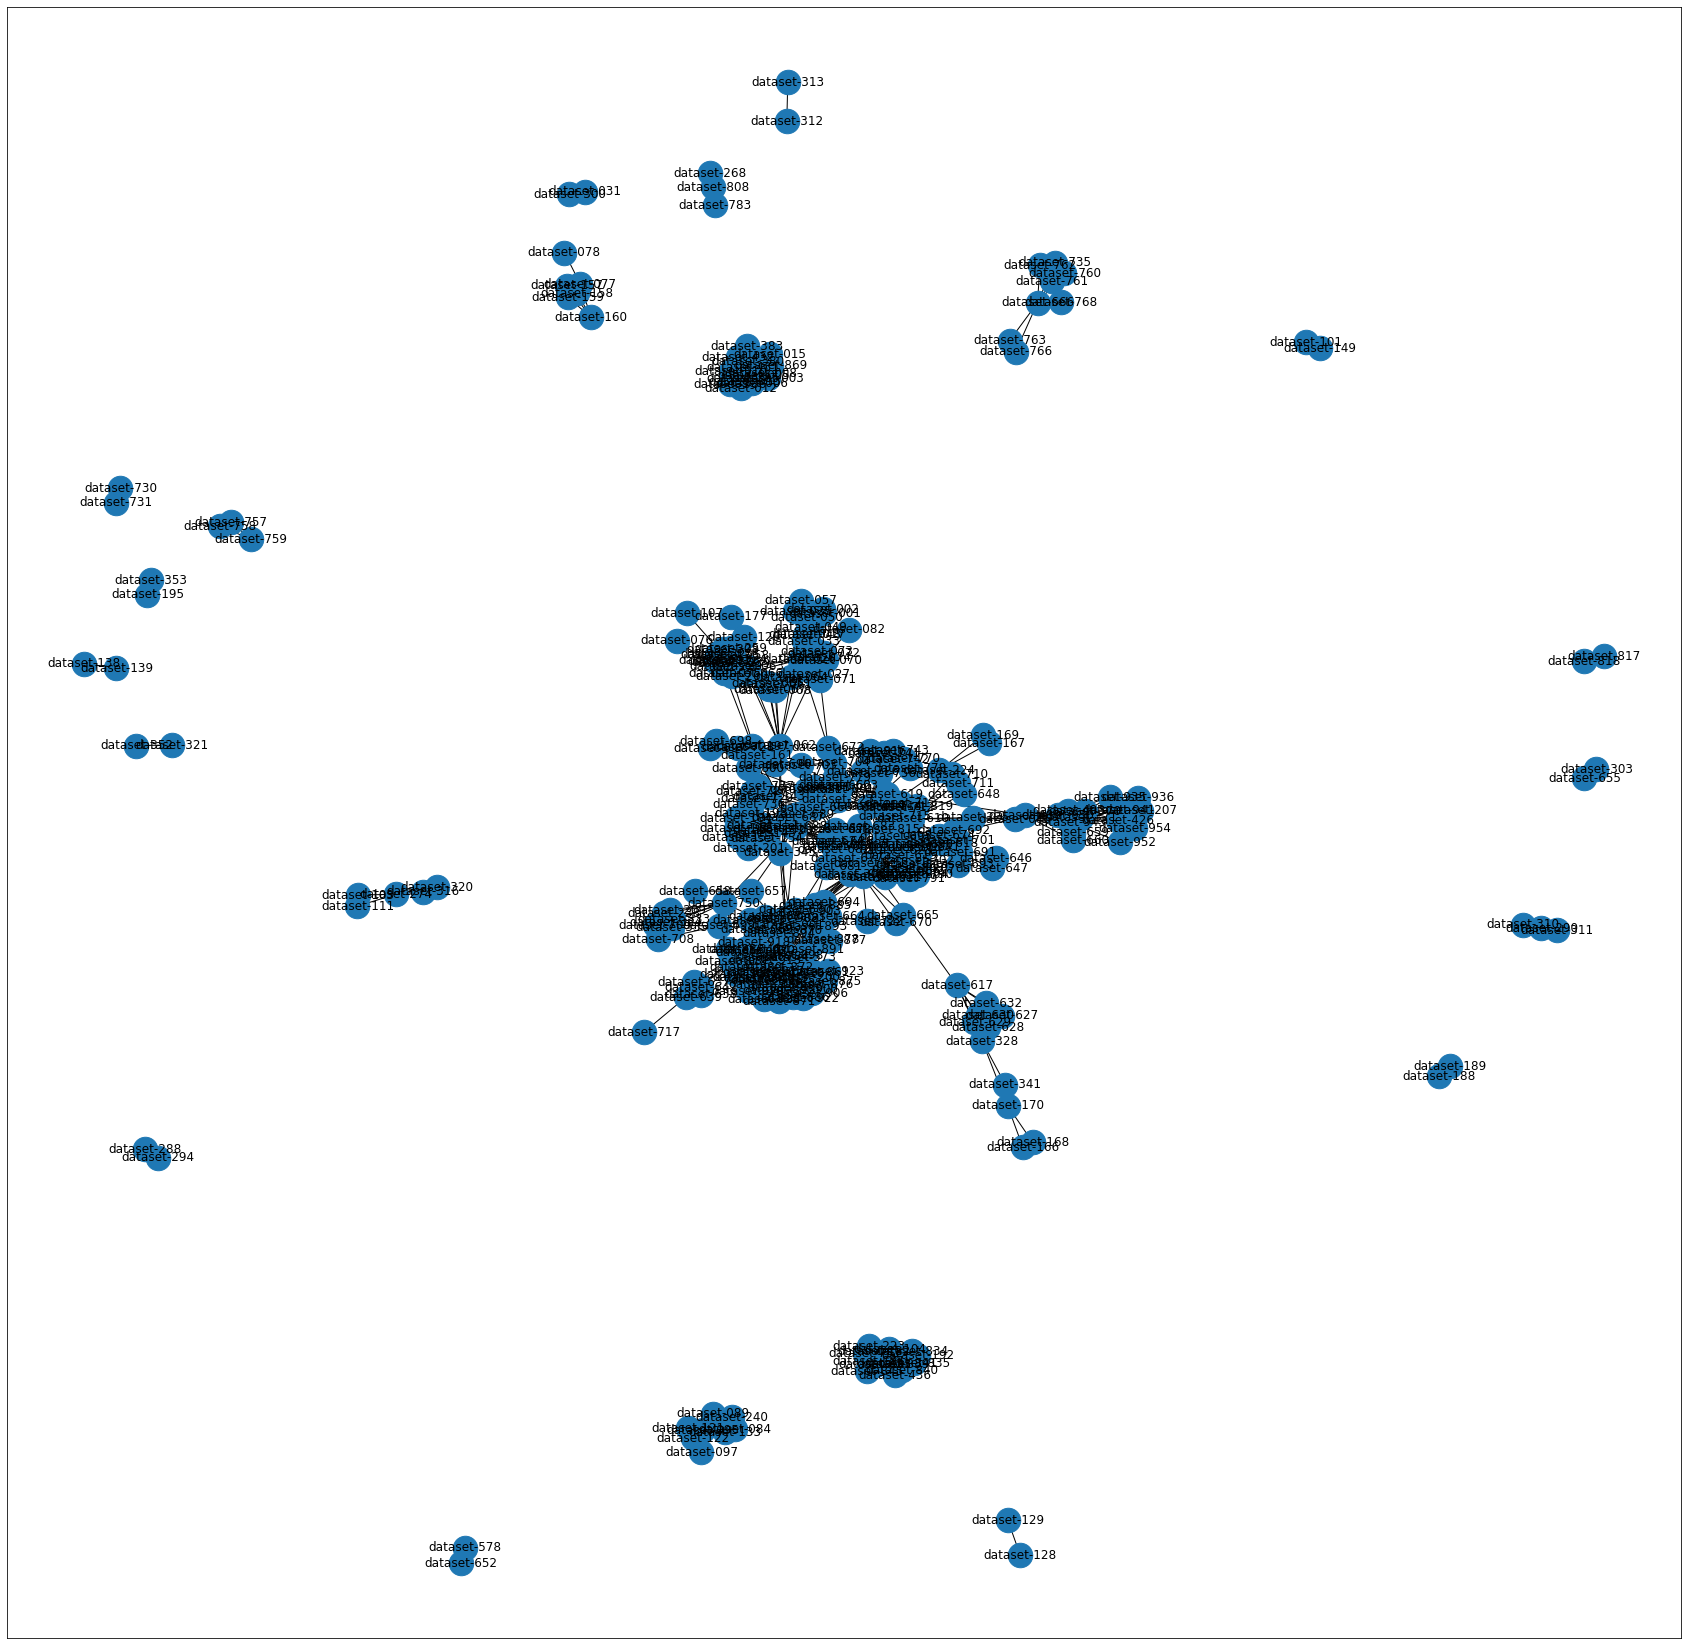

In [27]:
# create networkx graph from all dataset links network object

G = nx.from_pandas_edgelist(mat_network,  edge_attr='weight')
plt.figure(figsize=(30,30))
pos = nx.spring_layout(G, scale=7) 
nx.draw_networkx(G, pos, node_size=600)

# TODO: improve graphic

In [28]:
# datasets with >=5 source-target links (arbitrary choice), sorted

mat_network_toplinks = mat_network[mat_network['weight']>=5].sort_values(by='weight', ascending=False).reset_index(drop=True)

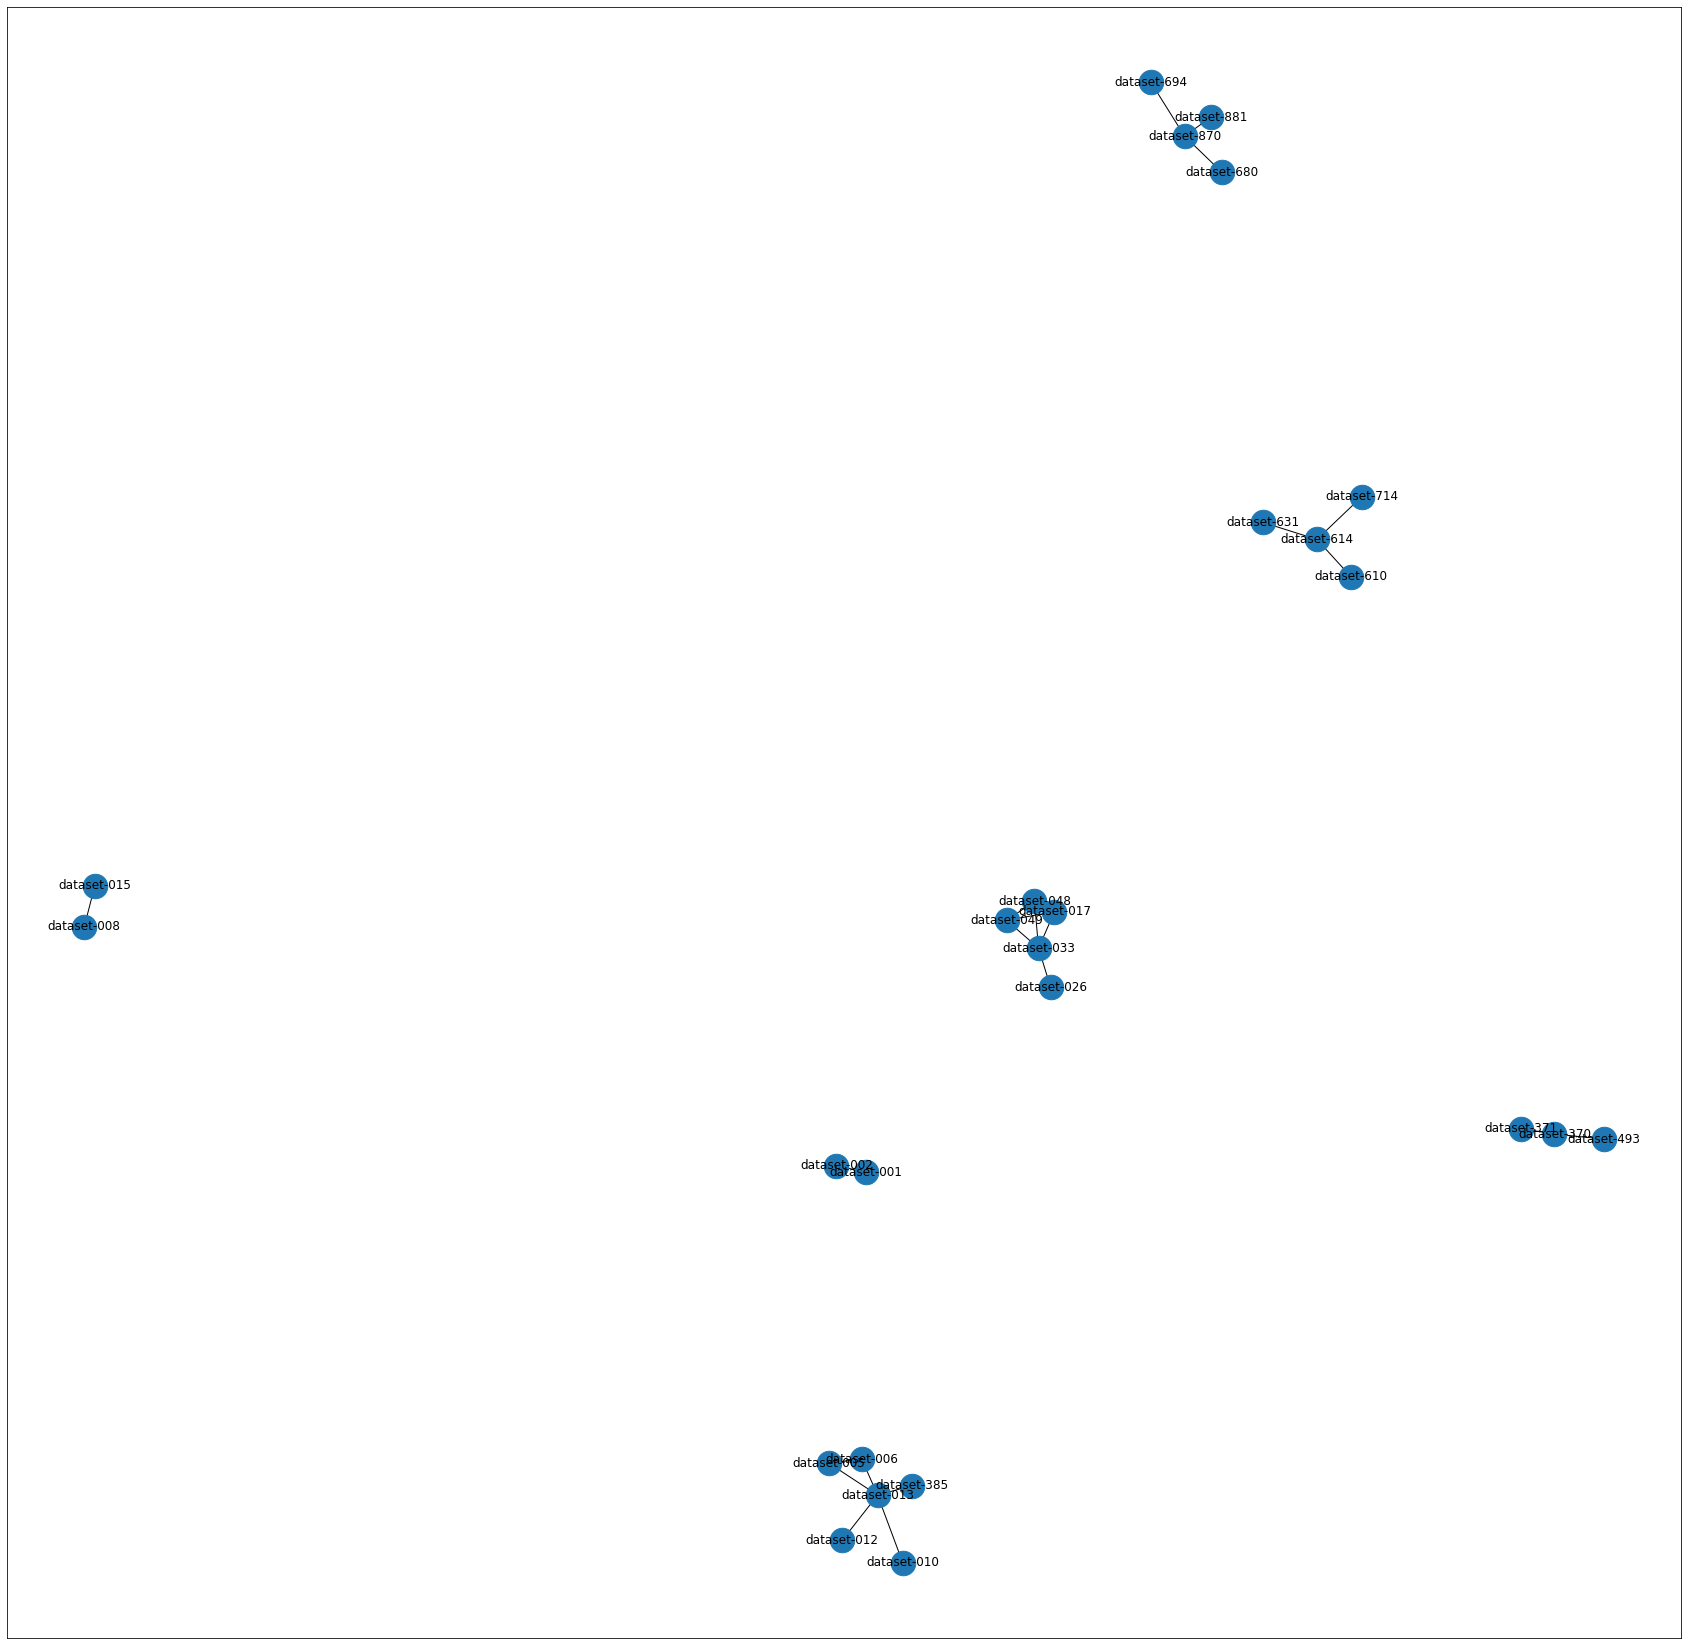

In [29]:
# create networkx graph object from dataset links network - only dataset pairs with >=5 links

G = nx.from_pandas_edgelist(mat_network_toplinks,  edge_attr='weight')
plt.figure(figsize=(30,30))
pos = nx.spring_layout(G, scale=7)
nx.draw_networkx(G, pos, node_size=600)

# TODO: improve graphic

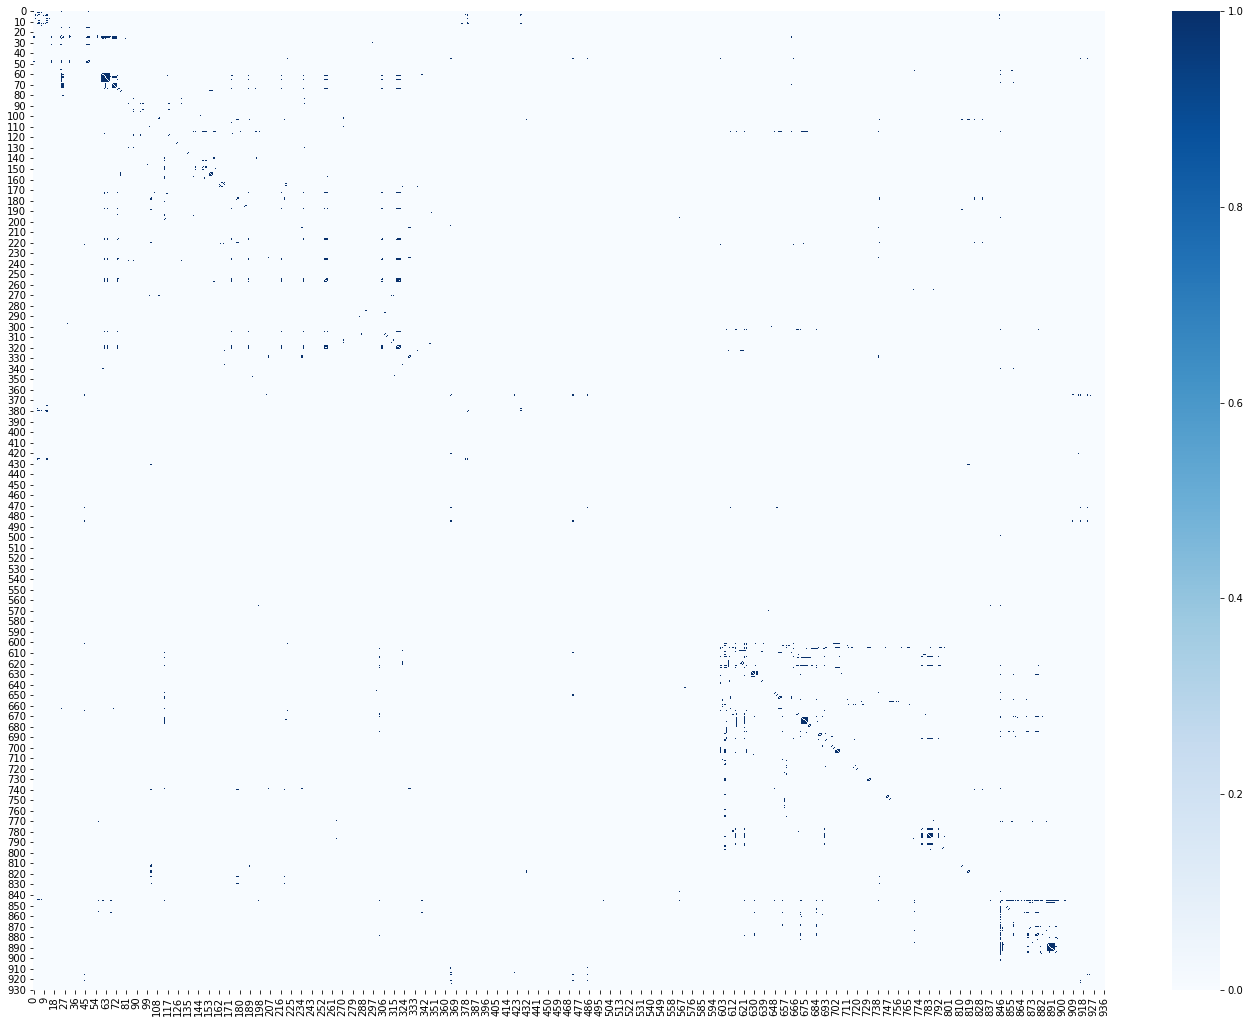

In [30]:
# Draw the heatmap, set vamx = 1 to get a clear view

f = plt.figure(figsize=(24,18))
sns.heatmap(mat, vmax=1, cmap='Blues')

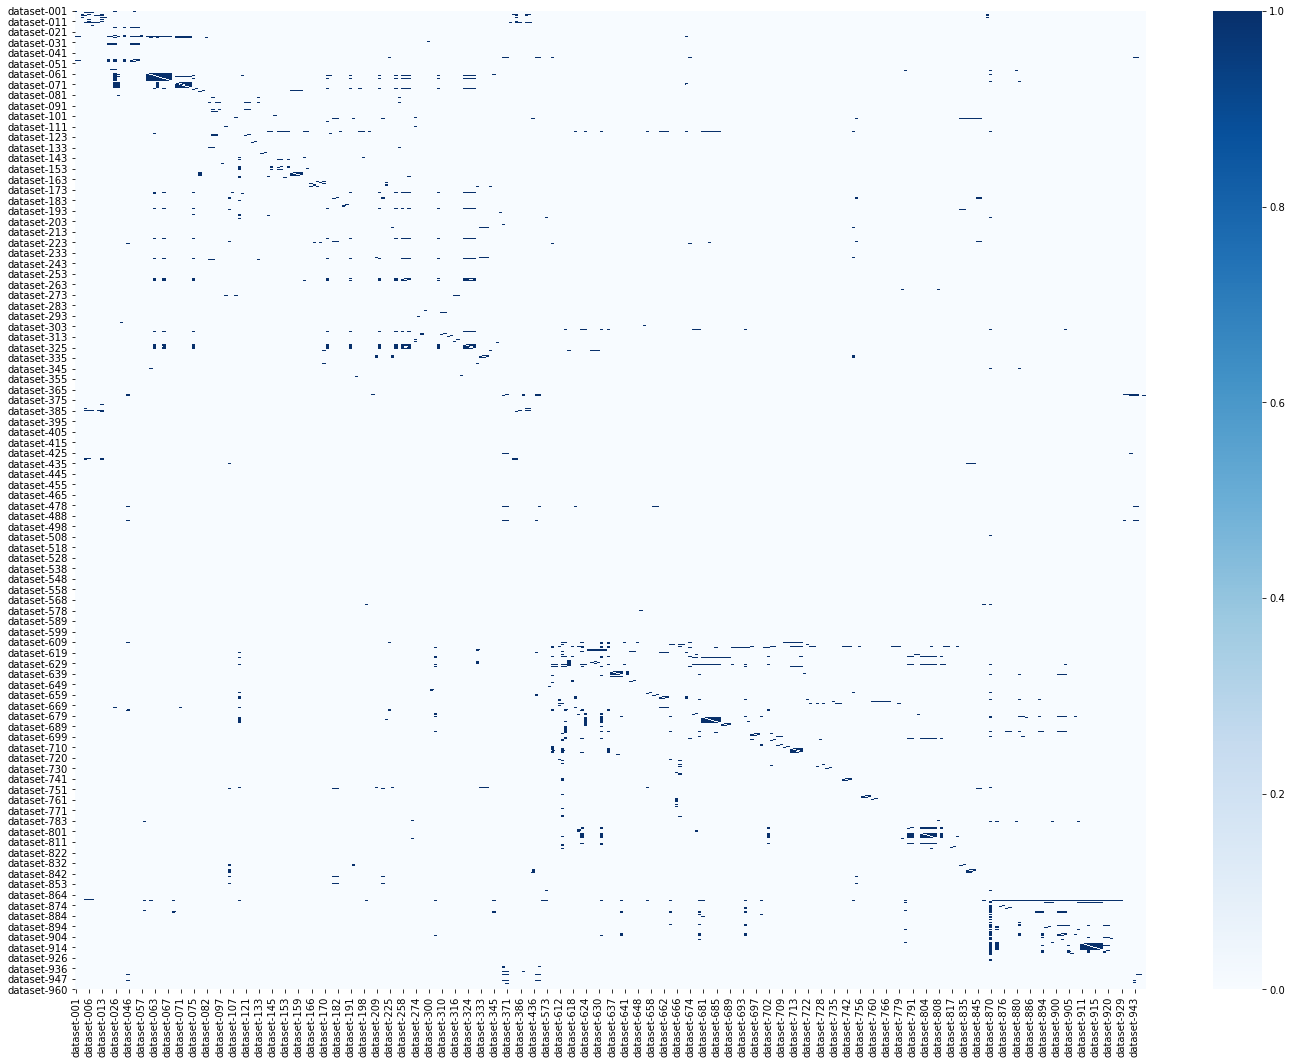

In [31]:
f = plt.figure(figsize=(24,18))
sns.heatmap(mat_df_filled, vmax=1, cmap='Blues')

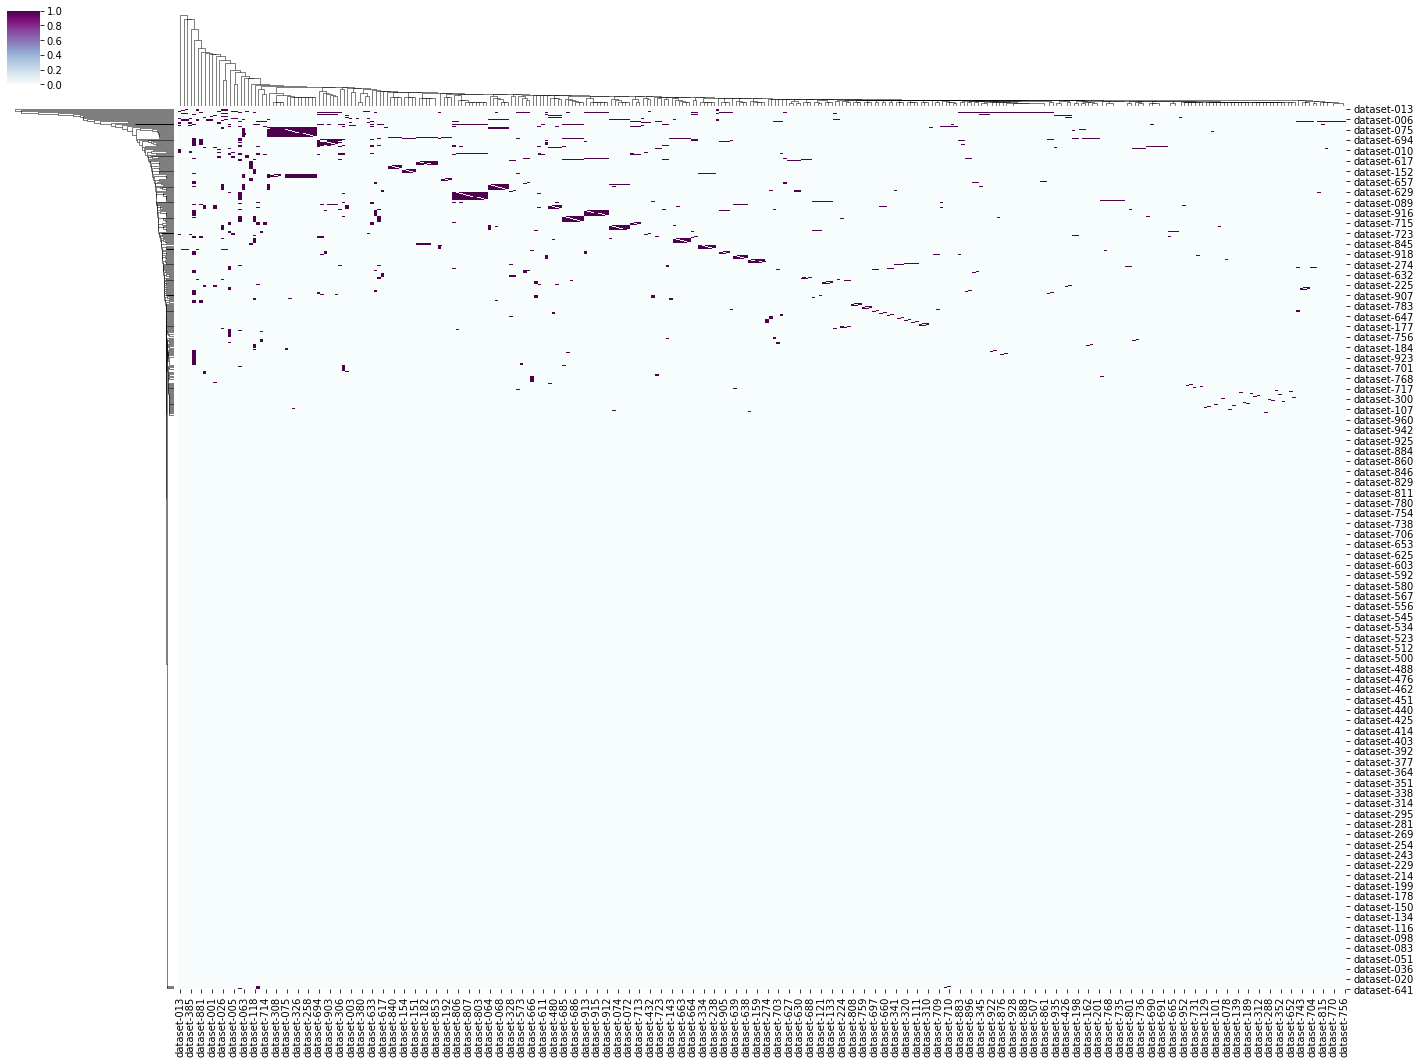

In [35]:
# attempt at dendrogram

sns.clustermap(mat_df_filled,figsize=(24,18), cmap="BuPu",vmax=1)